# Este arquivo contém o desenvolvimento para o desafio final do Bootcamp de Analista de dados do IGTI

1) Iniciar a seção SPARK

In [38]:
from pyspark.sql import SparkSession #importa a biblioteca que cria a seção do spark
from pyspark.sql.functions import * #importa a biblioteca do pyspark sql para ordenar dados na forma ascendente

from pyspark.ml import Pipeline # importa o Pipeline para uso da análise de ML
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer # importanto bibliotecas para transformação dos dados categóricos
from pyspark.ml.classification import LogisticRegression #define o modelo de regressão logística
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # importa a biblioteca para avaliar o modelo desenvolvido

In [2]:
#inicia a seção para a utilização do spark
spark = SparkSession.builder.appName("desafio_IGTI").getOrCreate() #cria a seção caso não exista ou obtém a já criada

In [3]:
diretorio_dataset="./healthcare-dataset-stroke-data.csv"  #diretório que contém o arquivo a ser utilizado

In [4]:
dataset_desafio = spark.read.format("csv").options(header="true", inferschema="true").load(diretorio_dataset)  #realiza a leitura do dataset

In [5]:
dataset_desafio.printSchema() #mostra o esquema inferido pelas variáveis

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



Respectivamente, quantas variáveis do tipo string e inteira existem no dataset? R. String: 5 e Integer: 4  

Quantas instâncias e atributos, respectivamente, existem no dataset? R. 5110

In [6]:
#número de instancias no dataset
dataset_desafio.count()

5110

Conhecendo o dataset

In [7]:
dataset_desafio.show() #mostra as linhas iniciais do dataset

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [8]:
#seleção de colunas
dataset_desafio.select('age','hypertension').show(5)

+----+------------+
| age|hypertension|
+----+------------+
|67.0|           0|
|61.0|           0|
|80.0|           0|
|49.0|           0|
|79.0|           1|
+----+------------+
only showing top 5 rows



In [9]:
#agrupando os dados
dataset_desafio.groupby('gender','stroke').count().sort("count",ascending=True).show()

+------+------+-----+
|gender|stroke|count|
+------+------+-----+
| Other|     0|    1|
|  Male|     1|  108|
|Female|     1|  141|
|  Male|     0| 2007|
|Female|     0| 2853|
+------+------+-----+



Analisando o gráfico anterior, o que podemos dizer sobre o derrame entre homens e mulheres? R. Cerca de 5,1% dos homens apresentados no dataset apresentaram derrame e cerca de 4,7% das mulheres no dataset apresentaram derrame. Com isso, podemos dizer que a incidência de derrame nos homens do dataset é maior que com as mulheres.

In [10]:
#agrupando os dados
dataset_desafio.groupby('smoking_status','stroke').count().sort("count",ascending=True).show()

+---------------+------+-----+
| smoking_status|stroke|count|
+---------------+------+-----+
|         smokes|     1|   42|
|        Unknown|     1|   47|
|formerly smoked|     1|   70|
|   never smoked|     1|   90|
|         smokes|     0|  747|
|formerly smoked|     0|  815|
|        Unknown|     0| 1497|
|   never smoked|     0| 1802|
+---------------+------+-----+



In [11]:
#agrupando os dados
dataset_desafio.groupby('hypertension','stroke').count().sort("count",ascending=True).show()

+------------+------+-----+
|hypertension|stroke|count|
+------------+------+-----+
|           1|     1|   66|
|           0|     1|  183|
|           1|     0|  432|
|           0|     0| 4429|
+------------+------+-----+



O que podemos dizer sobre o gráfico anterior? R. Pela tabela anterior, segundo a população analisada, a probabilidade de uma pessoa desta população ter derrame sabendo que a mesma possui hipertensão é de 13,25% enquanto que a probabilidade de uma pessoa da população não hipertensa ter derrame é de 3,97%. desta forma, é possível inferir que pessoas com hipertensão são mais sucetíveis a apresentar um quadro de derrame cerebral.

In [12]:
dataset_desafio.groupby('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



O dataset está balanceado? R. Não, pois o dataset apresenta muito mais dados de pessoas com derrame do que de pessoas sem quadro de derrame cerebral.

In [13]:
#utilizando crosstab para contar a quantidade de indivíduos com que ganho mais de 50K pela idade
dataset_desafio.filter(dataset_desafio.gender== 'Female').count()

2994

In [14]:
#contando as classes
dataset_desafio.groupBy("work_type").agg({'work_type': 'count'}).sort(asc("count(work_type)")).show()

+-------------+----------------+
|    work_type|count(work_type)|
+-------------+----------------+
| Never_worked|              22|
|     Govt_job|             657|
|     children|             687|
|Self-employed|             819|
|      Private|            2925|
+-------------+----------------+



In [15]:
entradas_numericas  = ['age',"avg_glucose_level", "bmi"]
dataset_desafio.describe(entradas_numericas).show(truncate=False)

+-------+------------------+------------------+------------------+
|summary|age               |avg_glucose_level |bmi               |
+-------+------------------+------------------+------------------+
|count  |5110              |5110              |5110              |
|mean   |43.226614481409015|106.14767710371804|28.893236911794673|
|stddev |22.61264672311348 |45.28356015058193 |7.85406672968016  |
|min    |0.08              |55.12             |10.3              |
|max    |82.0              |271.74            |N/A               |
+-------+------------------+------------------+------------------+



Qual é a média das idades dos participantes da pesquisa? R. A média das idades é de 43 anos

<AxesSubplot:>

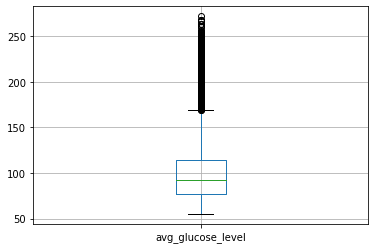

In [16]:
#boxplot

dataset_desafio.select('avg_glucose_level').toPandas().boxplot()

In [17]:
dataset_desafio.select('avg_glucose_level').toPandas().describe()

,avg_glucose_level
count,5110.000000
mean,106.147677
std,45.283560
min,55.120000
25%,77.245000
50%,91.885000
75%,114.090000
max,271.740000


Pelo gráfico anterior, qual é o valor da mediana? R.: 91,885

Pelo gráfico anterior, o que podemos dizer sobre a existência ou não de outliers? R. Pelo gráfico do boxplot, é possível identificar que diversos valores de glicose se encontram acima do terceiro quadrante, logo isso indica a presença de possíveis outliers na coluna de nível médio de glicose.

<AxesSubplot:>

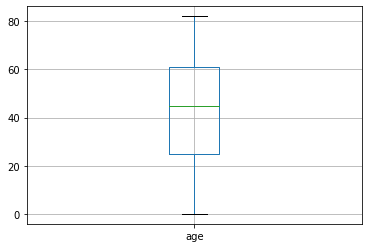

In [18]:
#boxplot
dataset_desafio.select('age').toPandas().boxplot()

In [19]:
dataset_desafio.select('age').toPandas().describe()

,age
count,5110.000000
mean,43.226614
std,22.612647
min,0.080000
25%,25.000000
50%,45.000000
75%,61.000000
max,82.000000


Pelo gráfico anterior, qual é o valor do primeiro quartil? R. 25

Pelo gráfico anterior, o que podemos dizer sobre os outliers? R. Através da análise de boxplot é possível identificar que não há outliers presentes na coluna de idade.

3) Pré-processamento dos dados

In [20]:
#contando a quantidade de valores desconhecidos
dataset_desafio.groupby('Residence_type').agg({'Residence_type': 'count'}).sort(asc("count(Residence_type)")).show()

+--------------+---------------------+
|Residence_type|count(Residence_type)|
+--------------+---------------------+
|         Rural|                 2514|
|         Urban|                 2596|
+--------------+---------------------+



In [21]:
# substituindo valores NA pela média
mean = dataset_desafio.select(mean(dataset_desafio['bmi'])).collect()
mean_bmi = mean[0][0]
dataset_desafio = dataset_desafio.na.fill(mean_bmi,['bmi'])

In [22]:
#aplicando o filtro para as colunas que possuem valores não conhecidos
dataset_filtrado=dataset_desafio.filter((dataset_desafio['bmi'] != 'N/A') & (dataset_desafio['smoking_status'] > 'Unknown'))

In [24]:
#define a transformação para a variável "gender"
stringIndexer_gender=StringIndexer(inputCol="gender", outputCol="gender_encoded")  #label encoding
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec") #one-hot encoding

In [25]:
#define a transformação para a variável "ever_married"
stringIndexer_married=StringIndexer(inputCol="ever_married", outputCol="ever_married_encoded") #label encoding
encoder_married = OneHotEncoder(dropLast=False, inputCol="ever_married_encoded", outputCol="marriedVec") #one-hot encoding

In [26]:
#define a transformação para a variável "work_type"
stringIndexer_work=StringIndexer(inputCol="work_type", outputCol="work_type_encoded")  #label encoding
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec") #one-hot encoding

In [27]:
#define a transformação para a variável "Residence_type"
stringIndexer_residence=StringIndexer(inputCol="Residence_type", outputCol="Residence_type_encoded")  #label encoding
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec") #one-hot encoding

In [28]:
#define a transformação para a variável "smoking_status"
stringIndexer_smoking=StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")  #define o objeto
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")#one-hot encoding

In [29]:
#define a construção do vetor de entrada
colunas_entrada=['age','hypertension', 'heart_disease','avg_glucose_level','genderVec','marriedVec','workVec','residenceVec','smokingVec']
vetor_entrada = VectorAssembler(inputCols=colunas_entrada,outputCol='features')

In [30]:
#define a sequencia de transformações para o pipeline
sequencia_transformacoes=[stringIndexer_gender,stringIndexer_married,stringIndexer_work,stringIndexer_residence,stringIndexer_smoking,encoder_gender,encoder_married,encoder_work,encoder_residence,encoder_smoking,vetor_entrada]

In [31]:
# Aplicando o pipeline
pipeline = Pipeline(stages=sequencia_transformacoes)
pipelineModel = pipeline.fit(dataset_filtrado)
model = pipelineModel.transform(dataset_filtrado)

In [32]:
#mostrando parte dos dados para entrada
model.select('age','gender','genderVec','ever_married','marriedVec','features').show()

+----+------+-------------+------------+-------------+--------------------+
| age|gender|    genderVec|ever_married|   marriedVec|            features|
+----+------+-------------+------------+-------------+--------------------+
|67.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|80.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|49.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,10...|
|81.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,5,7,9,14...|
|74.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,2,3,5,7,...|
|69.0|Female|(3,[0],[1.0])|          No|(2,[1],[1.0])|(19,[0,3,4,8,9,14...|
|81.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,9,...|
|61.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,4,7,11...|
|54.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female

In [33]:
#dividindo o dataset entre teste e treinamento
train_data, test_data = model.randomSplit([.8,.2],seed=1)

In [34]:
#mostrando os dados de treinamento
train_data.show(5)

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+-------------+-------------+-------------+-------------+--------------------+
| id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|gender_encoded|ever_married_encoded|work_type_encoded|Residence_type_encoded|smoking_status_encoded|    genderVec|   marriedVec|      workVec| residenceVec|   smokingVec|            features|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+--------------+--------------------+-----------------+----------------------+----------------------+-------------+-------------+-------------+-------------+-------------+--------------------+
| 84|  Male|55.0|           0| 

Realizando a previsão através da Regressão Logística

In [35]:
#instancia o objeto para a regressão logística
lr = LogisticRegression(labelCol="stroke",featuresCol="features", maxIter=100, regParam=0.3, )

# treina o modelo
linearModel = lr.fit(train_data)

In [36]:
#realiza a previsão utilizando o modelo de regressão logística
previsao_regressao = linearModel.transform(test_data)

In [39]:
#avaliando a classificação realizada pela regressão logística
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
acuracia_regressao = acc_evaluator.evaluate(previsao_regressao)
print('Regressão Logística: {0:2.2f}%'.format(acuracia_regressao*100))

Regressão Logística: 94.31%


Desta forma, através do modelo desenvolvido, é possível utilizar dos dados de cada indivíduo para predizer a incidência de derrame cerebral no mesmo. Entretanto, como o dataset não está balanceado, faz-se necessário adquirir mais dados para se obter uma predição mais fidedigna.